In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

from prophet import Prophet

In [2]:
# Load the data file
file_path = "./european_wholesale_electricity_price_data_daily.csv"

# Load the daily electricity price data
df_daily = pd.read_csv(file_path)

# Convert the Date column to datetime format
df_daily["Date"] = pd.to_datetime(df_daily["Date"])

# Filter for Sweden's electricity prices
df_sweden = df_daily[df_daily["Country"] == "Sweden"]

# Extract data from Feb 1 to March 3, 2024
start_date = "2024-02-01"
end_date = "2024-03-03"
df_sweden_filtered = df_sweden[(df_sweden["Date"] >= start_date) & (df_sweden["Date"] <= end_date)]

# Reset the index
df_sweden_filtered = df_sweden_filtered.reset_index(drop=True)

# Ensure the data is sorted by date
df_sweden_filtered = df_sweden_filtered.sort_values(by="Date")

# Extract the time series
prices = df_sweden_filtered["Price (EUR/MWhe)"].values
dates = df_sweden_filtered["Date"].values

# Display the extracted data
print('Sweden Electricity Prices (Feb 1 - March 3, 2024)')
print(df_sweden_filtered.iloc[:, [2, 3]].head(10))

Sweden Electricity Prices (Feb 1 - March 3, 2024)
        Date  Price (EUR/MWhe)
0 2024-02-01              7.17
1 2024-02-02             21.19
2 2024-02-03              1.00
3 2024-02-04             14.00
4 2024-02-05             45.31
5 2024-02-06             60.67
6 2024-02-07             80.88
7 2024-02-08             86.98
8 2024-02-09             68.65
9 2024-02-10             65.87


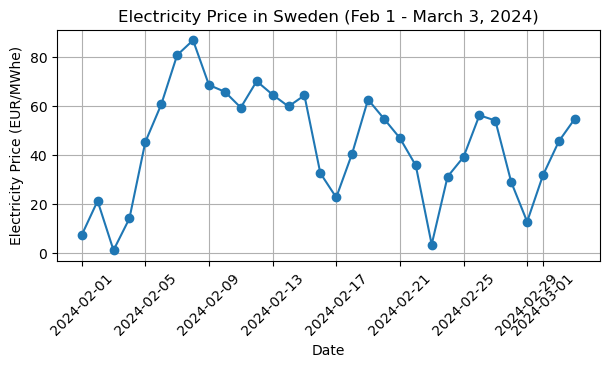

In [3]:
# Plot the filtered data
plt.figure(figsize=(7, 3))
plt.plot(df_sweden_filtered["Date"], df_sweden_filtered["Price (EUR/MWhe)"], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Electricity Price (EUR/MWhe)")
plt.title("Electricity Price in Sweden (Feb 1 - March 3, 2024)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

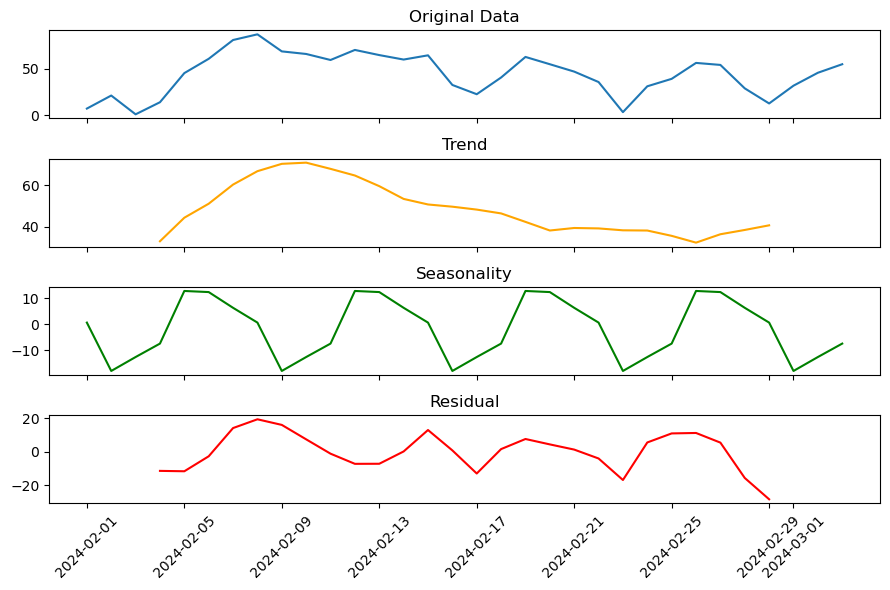

In [10]:
# Ensure the Date column is the index
# Check if 'Date' is already the index
if df_sweden_filtered.index.name != "Date":
    df_sweden_filtered.set_index("Date", inplace=True)


# Step 1: Compute the Trend using a Moving Average
window_size = 7  # Weekly trend assumption
df_sweden_filtered["Trend"] = df_sweden_filtered["Price (EUR/MWhe)"].rolling(window=window_size, center=True).mean()

# Step 2: Compute the Seasonality
# First, detrend the data (remove the trend)
df_sweden_filtered["Detrended"] = df_sweden_filtered["Price (EUR/MWhe)"] - df_sweden_filtered["Trend"]

# Compute the average seasonal effect for each day in a week (assuming 7-day seasonality)
df_sweden_filtered["DayOfWeek"] = df_sweden_filtered.index.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
seasonal_avg = df_sweden_filtered.groupby("DayOfWeek")["Detrended"].mean()

# Assign the seasonal component based on the day of the week
df_sweden_filtered["Seasonality"] = df_sweden_filtered["DayOfWeek"].map(seasonal_avg)

# Step 3: Compute the Residuals
df_sweden_filtered["Residual"] = df_sweden_filtered["Price (EUR/MWhe)"] - df_sweden_filtered["Trend"] - df_sweden_filtered["Seasonality"]

# Step 4: Plot the Components
fig, axes = plt.subplots(4, 1, figsize=(9, 6), sharex=True)

# Original Data
axes[0].plot(df_sweden_filtered.index, df_sweden_filtered["Price (EUR/MWhe)"], label="Original Data")
axes[0].set_title("Original Data")
# axes[0].legend()

# Trend
axes[1].plot(df_sweden_filtered.index, df_sweden_filtered["Trend"], label="Trend", color="orange")
axes[1].set_title("Trend")
# axes[1].legend()

# Seasonality
axes[2].plot(df_sweden_filtered.index, df_sweden_filtered["Seasonality"], label="Seasonality", color="green")
axes[2].set_title("Seasonality")
# axes[2].legend()

# Residual
axes[3].plot(df_sweden_filtered.index, df_sweden_filtered["Residual"], label="Residual", color="red")
axes[3].set_title("Residual")
# axes[3].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# Zeroth differencing to make data stationary
prices_diff = ((prices)) 

# Check stationarity using ADF test
result = adfuller(prices_diff)
adf_statistic = result[0]
p_value = result[1]
print(adf_statistic, p_value)

-2.400740389688652 0.14152754820738156


In [6]:
# First differencing to make data stationary
prices_diff = (np.diff(prices)) 

# Check stationarity using ADF test
result = adfuller(prices_diff)
adf_statistic = result[0]
p_value = result[1]
print(adf_statistic, p_value)

-3.1285017417364736 0.024514580973201427


In [7]:
# # Second differencing to make data stationary
# prices_diff = np.diff(np.diff(prices)) 

# # Check stationarity using ADF test
# result = adfuller(prices_diff)
# adf_statistic = result[0]
# p_value = result[1]
# print(adf_statistic, p_value)

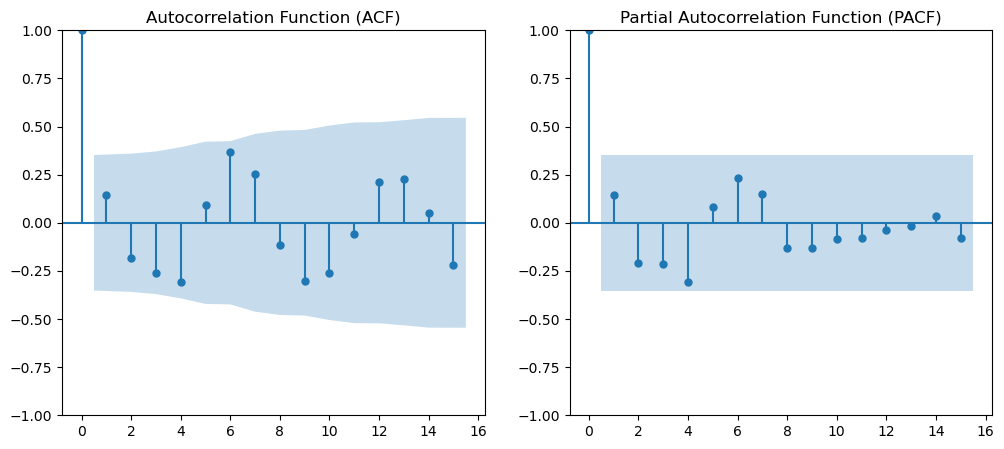

In [8]:
# Determine the maximum number of lags (50% of data length)
max_lags = min(len(prices_diff) // 2, 20)  # Ensure we do not exceed 50% of sample size

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot (for MA(q))
plot_acf(prices_diff, lags=max_lags, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot (for AR(p))
plot_pacf(prices_diff, lags=max_lags, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [9]:
# Compute ACF and PACF values
acf_values = acf(prices_diff, nlags=max_lags, fft=False)
pacf_values = pacf(prices_diff, nlags=max_lags)

N = len(prices_diff)

# Remove lag 0 from ACF and PACF values
acf_values_corrected = acf_values[1:]  # Exclude lag 0
pacf_values_corrected = pacf_values[1:]  # Exclude lag 0
lags_corrected = np.arange(1, len(acf_values))  # Start lags from 1

# Compute the 95% confidence threshold
confidence_threshold = 1.96 / np.sqrt(N)

# Identify statistically significant lags (outside the shaded region)
acf_significant_strict = np.abs(acf_values_corrected) > confidence_threshold
pacf_significant_strict = np.abs(pacf_values_corrected) > confidence_threshold

# Extract the highest significant lag for p (PACF) and q (ACF)
significant_pacf_lags = lags_corrected[pacf_significant_strict]
significant_acf_lags = lags_corrected[acf_significant_strict]

# Select the maximum lag for p and q
best_p = max(significant_pacf_lags) if len(significant_pacf_lags) > 0 else None
best_q = max(significant_acf_lags) if len(significant_acf_lags) > 0 else None

# Return the best p and q values found
print(best_p, best_q)


4 6


(2, 1, 2)


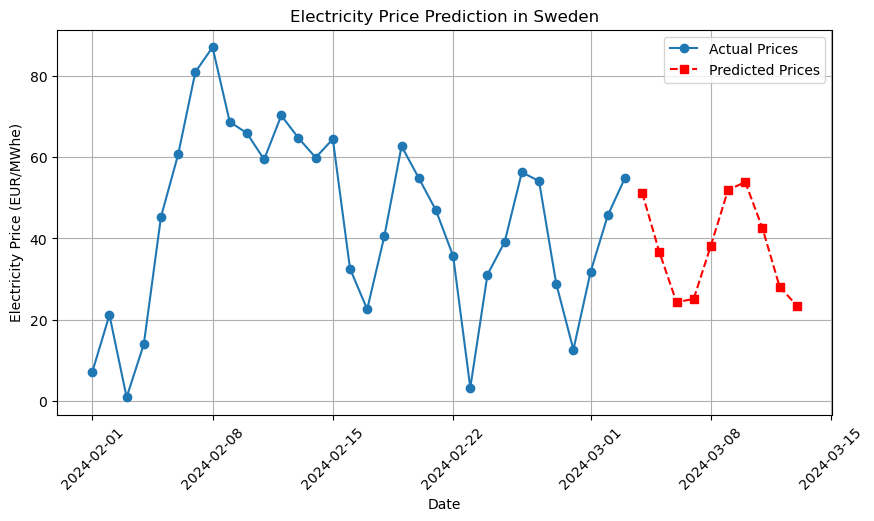

Predicted Electricity Prices in Sweden
        Date  Predicted Price (EUR/MWhe)
0 2024-03-04                   51.203358
1 2024-03-05                   36.685890
2 2024-03-06                   24.338747
3 2024-03-07                   25.147470
4 2024-03-08                   38.269054
5 2024-03-09                   51.893188
6 2024-03-10                   53.871262
7 2024-03-11                   42.548237
8 2024-03-12                   28.140445
9 2024-03-13                   23.518988


In [10]:
# Define range for p, d, q
p_range = range(0, 3)  # Test p values from 0 to 2
d_range = range(0, 3)  # Test d values from 0 to 2
q_range = range(0, 3)  # Test q values from 0 to 2

# Generate all possible (p,d,q) combinations
pdq_combinations = list(itertools.product(p_range, d_range, q_range))

best_aic = float("inf")
best_order = None
warnings.filterwarnings("ignore")  # Ignore warnings for failed models

# Iterate through different (p,d,q) values
for order in pdq_combinations:
    try:
        model = ARIMA(prices, order=order)
        model_fit = model.fit()
        aic = model_fit.aic  # Get AIC value
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except:
        continue

print(best_order)


# Define ARIMA model (AutoRegressive Integrated Moving Average)
# Using ARIMA(2,1,2) as a starting point, which can be optimized further
model = ARIMA(prices, order=best_order)
model_fit = model.fit()

# Predict future prices for the next 10 days
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates
future_dates = pd.date_range(start=dates[-1], periods=forecast_steps+1, freq='D')[1:]

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(dates, prices, label="Actual Prices", marker='o', linestyle='-')
plt.plot(future_dates, forecast, label="Predicted Prices", marker='s', linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Electricity Price (EUR/MWhe)")
plt.title("Electricity Price Prediction in Sweden")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Display the predicted prices
predicted_prices_df = pd.DataFrame({"Date": future_dates, "Predicted Price (EUR/MWhe)": forecast})
print('Predicted Electricity Prices in Sweden')
print(predicted_prices_df)

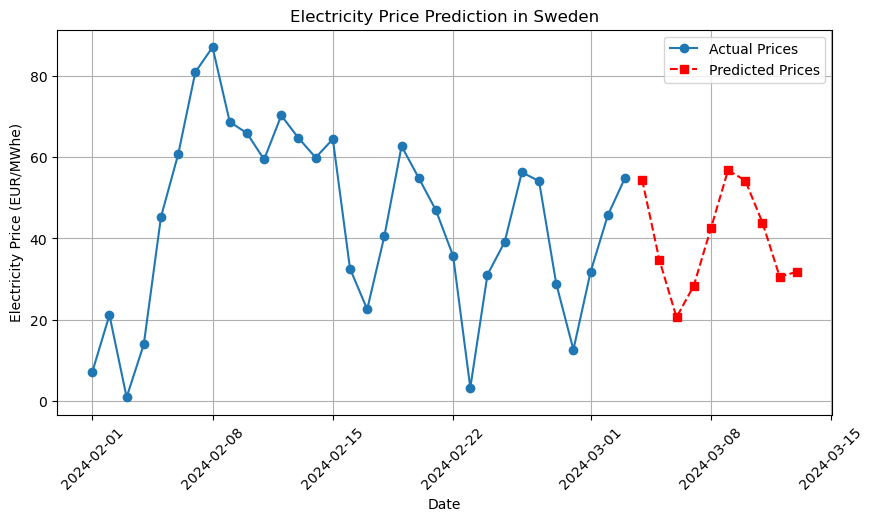

Predicted Electricity Prices in Sweden
        Date  Predicted Price (EUR/MWhe)
0 2024-03-04                   54.404914
1 2024-03-05                   34.772264
2 2024-03-06                   20.640230
3 2024-03-07                   28.334714
4 2024-03-08                   42.453869
5 2024-03-09                   56.783704
6 2024-03-10                   54.221941
7 2024-03-11                   43.911194
8 2024-03-12                   30.641939
9 2024-03-13                   31.790508


In [11]:
# Define ARIMA model (AutoRegressive Integrated Moving Average)
# Using ARIMA(2,1,2) as a starting point, which can be optimized further
model = ARIMA(prices, order=(4,0,6)) 
model_fit = model.fit()

# Predict future prices for the next 10 days
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates
future_dates = pd.date_range(start=dates[-1], periods=forecast_steps+1, freq='D')[1:]

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(dates, prices, label="Actual Prices", marker='o', linestyle='-')
plt.plot(future_dates, forecast, label="Predicted Prices", marker='s', linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Electricity Price (EUR/MWhe)")
plt.title("Electricity Price Prediction in Sweden")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Display the predicted prices
predicted_prices_df = pd.DataFrame({"Date": future_dates, "Predicted Price (EUR/MWhe)": forecast})
print('Predicted Electricity Prices in Sweden')
print(predicted_prices_df)

In [12]:
# Fit both models
model_212 = ARIMA(prices, order=(2,1,2)).fit()
model_416 = ARIMA(prices, order=(4,1,6)).fit()

# Get in-sample fitted values
pred_212 = model_212.fittedvalues
pred_416 = model_416.fittedvalues

# Align actual values with predictions
actual_212 = prices[len(prices) - len(pred_212):]  
actual_416 = prices[len(prices) - len(pred_416):]  

# Compute RMSE for both models
rmse_212 = np.sqrt(mean_squared_error(actual_212, pred_212))
rmse_416 = np.sqrt(mean_squared_error(actual_416, pred_416))

print(f"RMSE (2,1,2): {rmse_212}")
print(f"RMSE (4,1,6): {rmse_416}")


RMSE (2,1,2): 14.09963476843293
RMSE (4,1,6): 13.444089441185552


In [13]:
from pmdarima import auto_arima
auto_model = auto_arima(prices, seasonal=False, stepwise=True, trace=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=342.902, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=276.806, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=312.027, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=277.812, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=277.444, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=279.141, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=274.051, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=293.536, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=272.623, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=274.541, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=274.558, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=273.189, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=276.506, Time=0.07 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Tota